# <font style="color:black">Basic Image Enhancement Using Mathematical Operations</font>
Image Processing techniques take advantage of mathematical operations to achieve different results. Most often we arrive at an enhanced version of the image using some basic operations. We will take a look at some of the fundamental operations often used in computer vision pipelines. In this notebook we will cover:

* Arithmetic Operations like addition, multiplication
* Generating Histograms
* Blurring
* Thresholding, Dilation + Erosion & Masking
* Bitwise Operations like OR, AND, XOR

In [87]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
%matplotlib inline
from IPython.display import Image


### <font color="green">Original image</font>

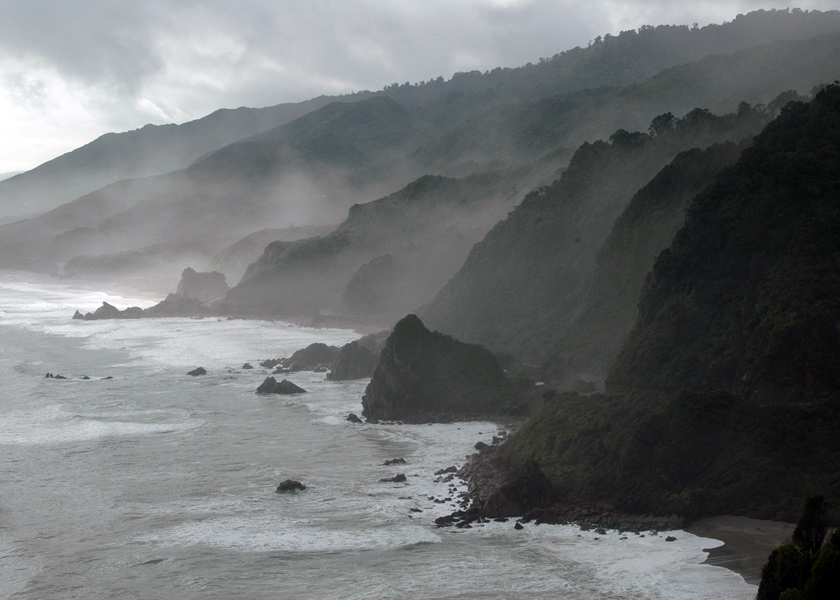

In [88]:
img_bgr = cv2.imread("New_Zealand_Coast.jpg",cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Display 18x18 pixel image.
Image(filename='New_Zealand_Coast.jpg')

## Addition or Brightness
The first operation we discuss is simple addition of images. This results in increasing or decreasing the brightness of the image since we are eventually increasing or decreasing the intensity values of each pixel by the same amount. So, this will result in a global increase/decrease in brightness.

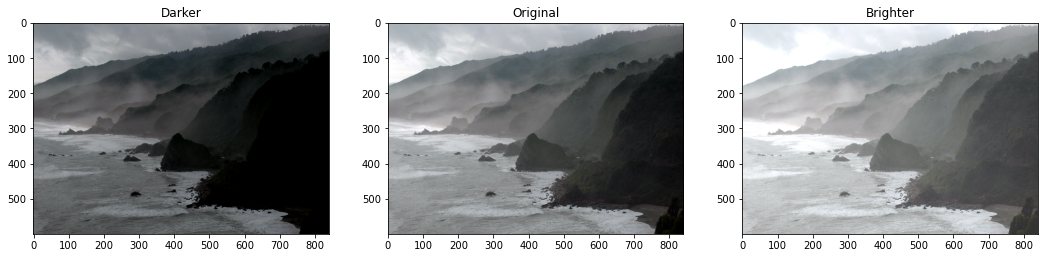

In [89]:
matrix = np.ones(img_rgb.shape, dtype = "uint8") * 50

img_rgb_brighter = cv2.add(img_rgb, matrix)
img_rgb_darker   = cv2.subtract(img_rgb, matrix)

# Show the images
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(img_rgb_darker);  plt.title("Darker");
plt.subplot(132); plt.imshow(img_rgb);         plt.title("Original");
plt.subplot(133); plt.imshow(img_rgb_brighter);plt.title("Brighter");

## Multiplication or Contrast
Just like addition can result in brightness change, multiplication can be used to improve the contrast of the image. 

Contrast is the difference in the intensity values of the pixels of an image. Multiplying the intensity values with a constant can make the difference larger or smaller ( if multiplying factor is < 1 ).

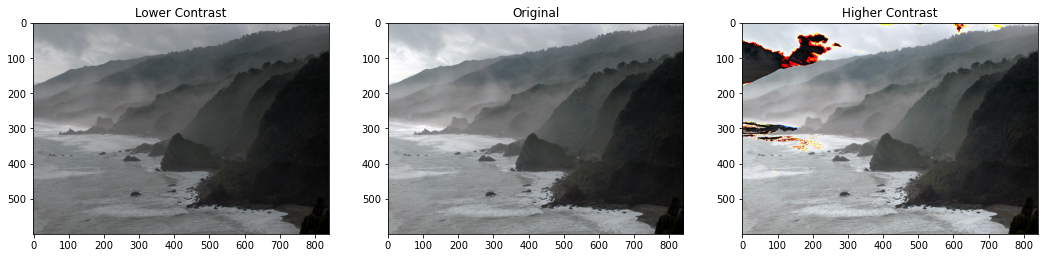

In [90]:
matrix1 = np.ones(img_rgb.shape) * .8
matrix2 = np.ones(img_rgb.shape) * 1.2

img_rgb_darker   = np.uint8(cv2.multiply(np.float64(img_rgb), matrix1))
img_rgb_brighter = np.uint8(cv2.multiply(np.float64(img_rgb), matrix2))

# Show the images
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(img_rgb_darker);  plt.title("Lower Contrast");
plt.subplot(132); plt.imshow(img_rgb);         plt.title("Original");
plt.subplot(133); plt.imshow(img_rgb_brighter);plt.title("Higher Contrast");

### <font color="green">What happened?</font>
Can you see the weird colors in some areas of the image after multiplication?

The issue is that after multiplying, the values which are already high, are becoming greater than 255. Thus, the overflow issue. How do we overcome this?

### <font color="green">Handling Overflow using np.clip</font>

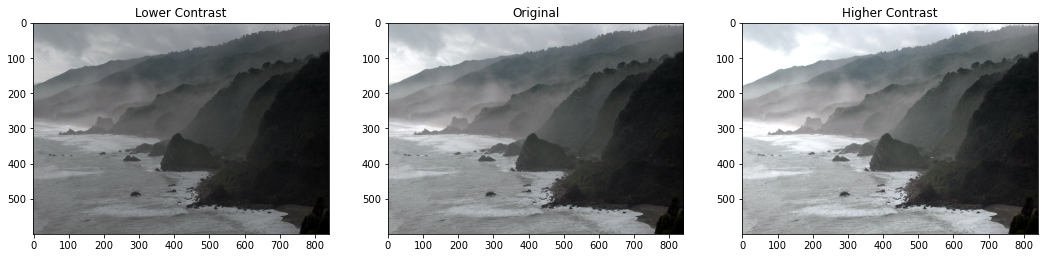

In [91]:
matrix1 = np.ones(img_rgb.shape) * .8
matrix2 = np.ones(img_rgb.shape) * 1.2

img_rgb_lower   = np.uint8(cv2.multiply(np.float64(img_rgb), matrix1))
img_rgb_higher  = np.uint8(np.clip(cv2.multiply(np.float64(img_rgb), matrix2),0,255))

# Show the images
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(img_rgb_lower);  plt.title("Lower Contrast");
plt.subplot(132); plt.imshow(img_rgb);         plt.title("Original");
plt.subplot(133); plt.imshow(img_rgb_higher);plt.title("Higher Contrast");

## Computing Histograms
We will be using the cv2.calcHist function to build our histograms:
    
    cv2.calcHist(images,channels,mask,histSize,ranges)
* images: This is the image that we want to compute a histogram for. Wrap it as a list: [myImage].
* channels: This is a list of indexes, where we specify the index of the channel we want to compute a histogram for. To compute a histogram of a grayscale image, the list would be [0]. To compute a histogram for all three red, green, and blue channels, the channels list would be [0,1,2].
* mask: If a mask is provided, a histogram will be computed for masked pixels only. If we do not have a mask or do not want to apply one, we can just provide a value of None.
* histSize: This is the number of bins we want to use when computing a histogram. This is a list, one for each channel we are computing a histogram for. The bin sizes do not all have to be the same.
* ranges: Here we specify The range of possible pixel values. Normally, this is [0, 256] for each channel, but if you are using a color space other than RGB (such as HSV), the ranges might be different

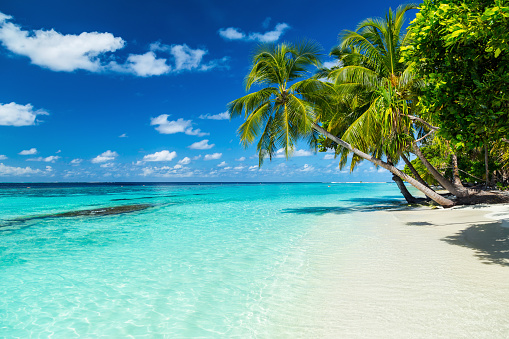

In [92]:
img_bgr = cv2.imread("beach.jpeg",cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Display 18x18 pixel image.
Image(filename='beach.jpeg')

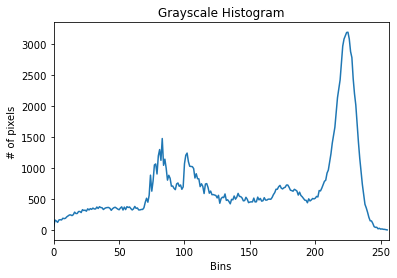

In [93]:
# GRayscale histogram
gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
gray_hist = cv2.calcHist([gray], [0], None, [256], [0,256] )

plt.figure()
plt.title('Grayscale Histogram')
plt.xlabel('Bins')
plt.ylabel('# of pixels')
plt.plot(gray_hist)
plt.xlim([0,256])
plt.show()

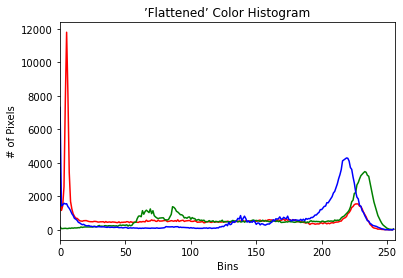

In [94]:
chans = cv2.split(img_rgb)
colors = ("r", "g", "b")
plt.figure()
plt.title("’Flattened’ Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
for (chan, color) in zip(chans, colors):
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    plt.plot(hist, color = color)
    plt.xlim([0, 256])

## Histogram Equalisation
Histogram equalization improves the contrast of an image by “stretching” the distribution of pixels.

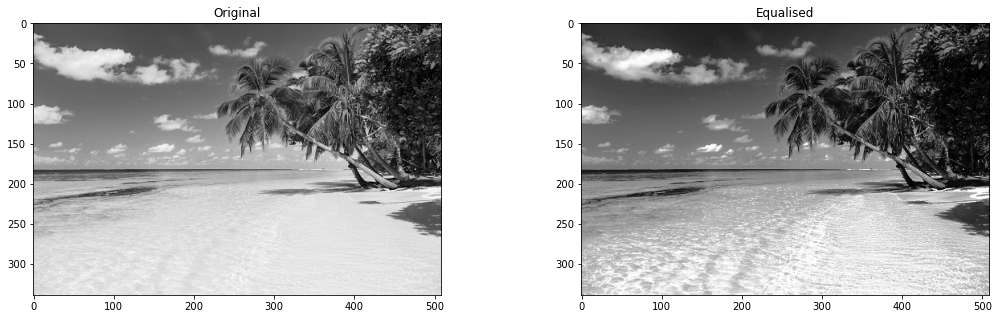

In [95]:
eq_img = cv2.equalizeHist(gray)
plt.figure(figsize=[18,5])
plt.subplot(121); plt.imshow(gray, cmap="gray");         plt.title("Original");
plt.subplot(122); plt.imshow(eq_img, cmap="gray");       plt.title("Equalised");

## Blurring and Smoothing
Blurring and smoothing are essential tools for a computer vision engineer. Its usually a precursor to more advance 
techniques like edge detection etc.

### Why do we Blur or Smoothen
![image](grainy_picture.png)

Most real pictures have some sort of grainyness or noise in them. For e.g. in the picture above we have shown how pixel values would look along a single axis. The value of the pixel is going from low to high and it won't be a smooth step function. It will be noisy and determining the point of transition is difficult. So we use smoothing to enable algorithms to identify a midpoint as point of transition.

![image](smoothened_grainy_picture.png)

Blurring and smoothing involves running a convolution with a small kernel.
We'll look at average, Gaussian, median and bilateral blurring techniques

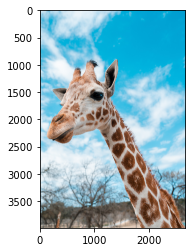

In [96]:
img_bgr = cv2.imread("giraffe.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

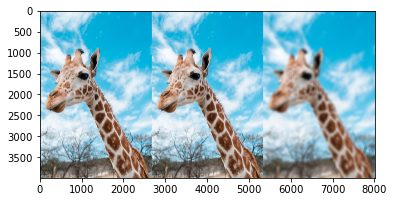

In [97]:
#Average blurring - takes in image and kernel size
blurred = np.hstack([ cv2.blur(img_rgb, (3, 3)), cv2.blur(img_rgb, (5, 5)), cv2.blur(img_rgb, (70, 70))])
plt.imshow(blurred)

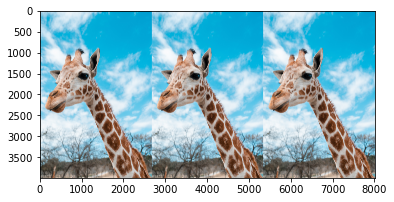

In [98]:
#Gaussian blur - (weighted) - third parameter is standard deviation of Gaussian function
blurred = np.hstack([ cv2.GaussianBlur(img_rgb, (3, 3), 0),cv2.GaussianBlur(img_rgb, (5, 5), 0), cv2.GaussianBlur(img_rgb, (7, 7), 0),])
plt.imshow(blurred)

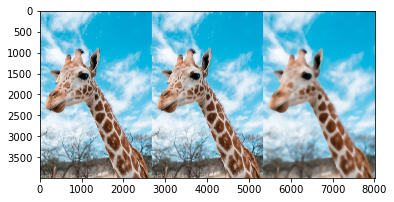

In [99]:
#Median blur - used to remove salt and pepper kind of noise (one value, assumes square kernel)
blurred = np.hstack([ cv2.medianBlur(img_rgb, 3), cv2.medianBlur(img_rgb, 5), cv2.medianBlur(img_rgb, 71)])
plt.imshow(blurred)

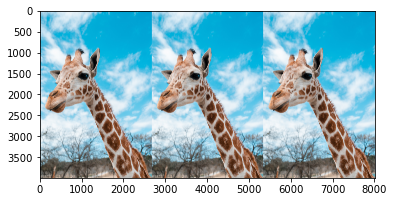

In [100]:
#Bilateral Blurring - params are (diameter, color, space)
"""Bilateral uses 2 Gaussians distributions. 
The first Gaussian function only considers spatial neigbbors, that is, pixels that appear close together in the (x, y) 
coordinate space of the image. The second Gaussian then models the pixel intensity of the neighborhood, 
ensuring that only pixels with similar intensity are included in the actual computation of the blur.
Overall, this method is able to preserve edges of an image, while still reducing noise, but is much slower.
"""
blurred = np.hstack([ cv2.bilateralFilter(img_rgb, 5, 21, 21), cv2.bilateralFilter(img_rgb, 7, 31, 31), cv2.bilateralFilter(img_rgb, 9, 41, 41)])
plt.imshow(blurred)

## Morphological Operations

The purpose of morphological operations is clean up noise like small white dots or black dots. They are often useful preprocessing steps before an OCR (Optical Character Recognition), where if used correctly they improve the quality of recognition.



## Image Thresholding
Binary Images have a lot of use cases in Image Processing. One of the most common use cases is that of creating masks. Image Masks allow us to process on specific parts of an image keeping the other parts intact. Image Thresholding is used to create Binary Images from grayscale images. You can use different thresholds to create different binary images from the same original image. 

### <font color="green">Function Syntax </font>

``` python
retval, dst = cv2.threshold( src, thresh, maxval, type[, dst] )
```

`dst`: The output array of the same size and type and the same number of channels as `src`.

The function has **4 required arguments**:

1. `src`: input array (multiple-channel, 8-bit or 32-bit floating point).
2. `thresh`: threshold value.
3. `maxval`: maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types.
4. `type`: thresholding type (see ThresholdTypes).


### <font color="green">Function Syntax </font>

``` python
dst = cv.adaptiveThreshold( src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst] )
```

`dst`	Destination image of the same size and the same type as src.

The function has **6 required arguments**:
1. `src`:	Source 8-bit single-channel image.

2. `maxValue`:	Non-zero value assigned to the pixels for which the condition is satisfied
3. `adaptiveMethod`:	Adaptive thresholding algorithm to use, see AdaptiveThresholdTypes. The BORDER_REPLICATE | BORDER_ISOLATED is used to process boundaries.
4. `thresholdType:`	Thresholding type that must be either THRESH_BINARY or THRESH_BINARY_INV, see ThresholdTypes.
5. `blockSize`:	Size of a pixel neighborhood that is used to calculate a threshold value for the pixel: 3, 5, 7, and so on.
6. `C`:	Constant subtracted from the mean or weighted mean (see the details below). Normally, it is positive but may be zero or negative as well.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

https://docs.opencv.org/4.5.1/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57
https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html

(572, 800)


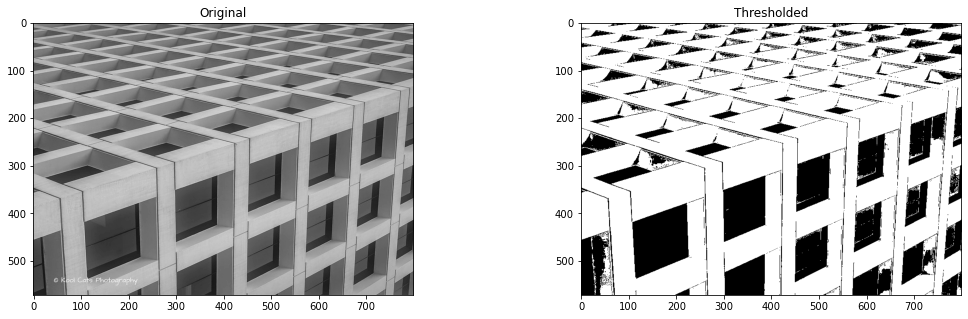

In [101]:
img_read = cv2.imread("building-windows.jpg", cv2.IMREAD_GRAYSCALE)
retval, img_thresh = cv2.threshold(img_read, 100, 255, cv2.THRESH_BINARY)

# Show the images
plt.figure(figsize=[18,5])
plt.subplot(121); plt.imshow(img_read, cmap="gray");         plt.title("Original");
plt.subplot(122); plt.imshow(img_thresh, cmap="gray");       plt.title("Thresholded");

print(img_thresh.shape)

## Application: Sheet Music Reader 
Suppose you wanted to build an application that could read (decode) sheet music. This is similar to 
Optical Character Recognigition (OCR) for text documents where the goal is to recognize text characters. In either application, one of the first steps in the processing pipeline is to isolate the important information in the image of a document (separating it from the background). This task can be accomplished with thresholding 
techniques. Let's take a look at an example.

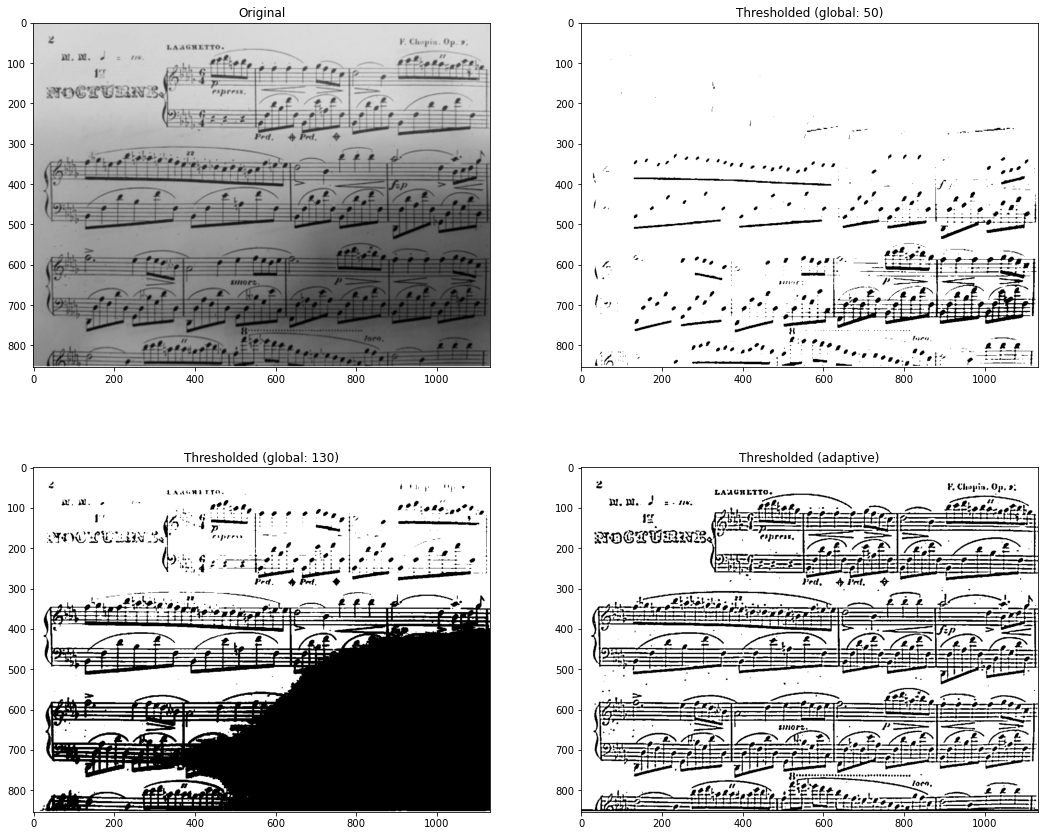

In [102]:
# Read the original image
img_read = cv2.imread("Piano_Sheet_Music.png", cv2.IMREAD_GRAYSCALE)

# Perform global thresholding
retval, img_thresh_gbl_1 = cv2.threshold(img_read,50, 255, cv2.THRESH_BINARY)

# Perform global thresholding
retval, img_thresh_gbl_2 = cv2.threshold(img_read,130, 255, cv2.THRESH_BINARY)

# Perform adaptive thresholding
img_thresh_adp = cv2.adaptiveThreshold(img_read, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 7)

# Show the images
plt.figure(figsize=[18,15])
plt.subplot(221); plt.imshow(img_read,        cmap="gray");  plt.title("Original");
plt.subplot(222); plt.imshow(img_thresh_gbl_1,cmap="gray");  plt.title("Thresholded (global: 50)");
plt.subplot(223); plt.imshow(img_thresh_gbl_2,cmap="gray");  plt.title("Thresholded (global: 130)");
plt.subplot(224); plt.imshow(img_thresh_adp,  cmap="gray");  plt.title("Thresholded (adaptive)");


### Dilation and Erosion
Dilation **expands** connected sets of 1's in a binary image - useful for growing features and filling holes and gaps

Erosion **shrinks** connected sets of 1's in a binary image - useful for shrinking features and removing bridges, branches, portrusions etc

![image](Dilation_and_Erosion.jpg)

(45, 199)


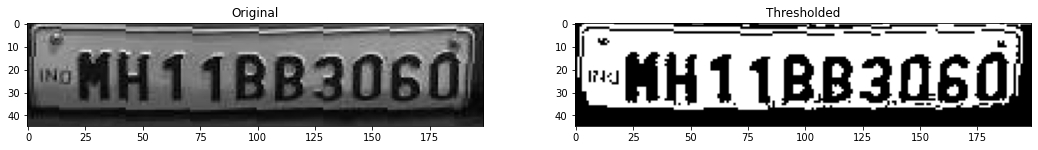

In [103]:
#read in image and threshold it to make it binary
img_read = cv2.imread("number_plate.jpeg", cv2.IMREAD_GRAYSCALE)
retval, img_thresh = cv2.threshold(img_read, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Show the images
plt.figure(figsize=[18,5])
plt.subplot(121); plt.imshow(img_read, cmap="gray");         plt.title("Original");
plt.subplot(122); plt.imshow(img_thresh, cmap="gray");       plt.title("Thresholded");

print(img_thresh.shape)

## Dilation
We first create a 3×3 kernel or matrix and then run a convolution over the entire image. Dilation increases the whitespace, reducing noise or small dark spots in the image. After small dark pixels are eliminated, the bigger numbers are now clearly delineated, but may be smaller.

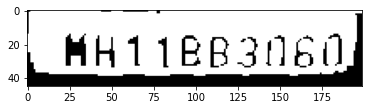

In [104]:
kernel = np.ones((3, 3), np.uint8)
dil_img = cv2.dilate(img_thresh, kernel, iterations=1)
plt.imshow(dil_img, cmap='gray')

## Erosion

We will use the same kernel. Erosion will make the dark letters a little bigger and easier to read.

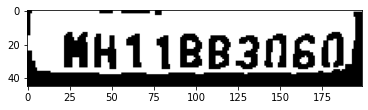

In [105]:
erd_img = cv2.erode(dil_img, kernel, iterations=1)
plt.imshow(erd_img, cmap='gray')

## Closure
OpenCV provides a higher level function which lets us do both the steps first dilation and then erosion with a MORPH_CLOSE. We get the same results as above.

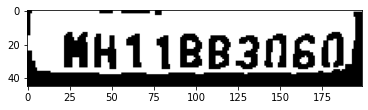

In [106]:
cls_img = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(cls_img, cmap='gray')

## Bitwise Operations

### <font style="color:rgb(8,133,37)">Function Syntax</font>

Example API for `cv2.bitwise_and()`. Others include: `cv2.bitwise_or()`, `cv2.bitwise_xor()`, `cv2.bitwise_not()`

``` python
dst = cv2.bitwise_and( src1, src2[, dst[, mask]] )
```

`dst`: Output array that has the same size and type as the input arrays.

The function has **2 required arguments**:

1. `src1`:	first input array or a scalar.
2. `src2`:	second input array or a scalar.

An important optional argument is:

1. `mask`:	optional operation mask, 8-bit single channel array, that specifies elements of the output array to be changed.


### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

https://docs.opencv.org/4.5.1/d0/d86/tutorial_py_image_arithmetics.html
https://docs.opencv.org/4.5.0/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14

(200, 499)


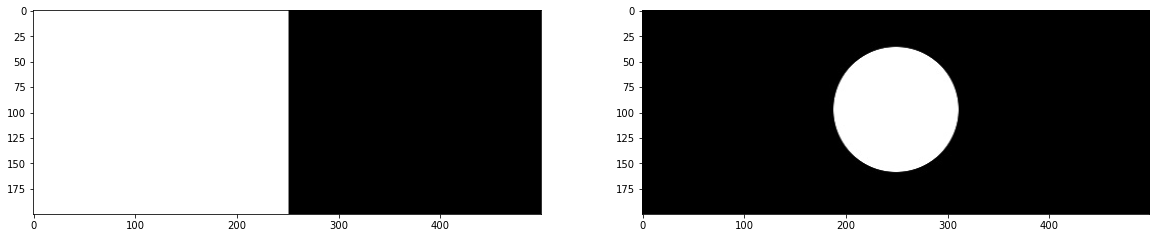

In [107]:
img_rec = cv2.imread("rectangle.jpg", cv2.IMREAD_GRAYSCALE)

img_cir = cv2.imread("circle.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=[20,5])
plt.subplot(121);plt.imshow(img_rec,cmap='gray')
plt.subplot(122);plt.imshow(img_cir,cmap='gray')
print(img_rec.shape)

### <font color="green">Bitwise AND Operator </font>

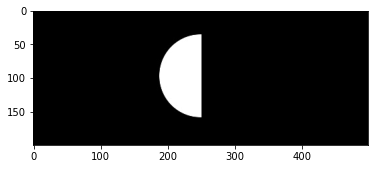

In [108]:
result = cv2.bitwise_and(img_rec, img_cir, mask = None)
plt.imshow(result,cmap='gray')

### <font color="green">Bitwise OR Operator </font>

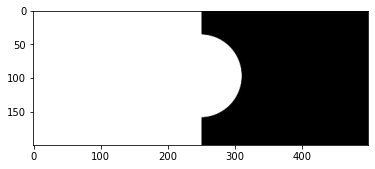

In [109]:
result = cv2.bitwise_or(img_rec, img_cir, mask = None)
plt.imshow(result,cmap='gray')

### <font color="green">Bitwise XOR Operator </font>

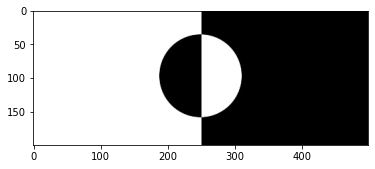

In [110]:
result = cv2.bitwise_xor(img_rec, img_cir, mask = None)
plt.imshow(result,cmap='gray')

## Application: Logo Manipulation

In this section we will show you how to fill in the white lettering of the Coca-Cola logo below with a background image.

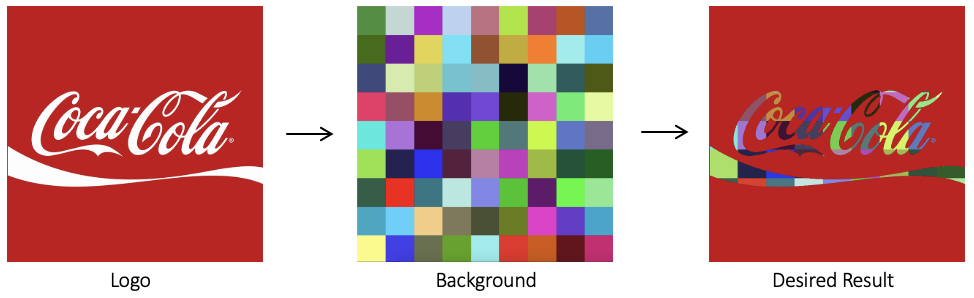

In [111]:
Image(filename='Logo_Manipulation.png')

### <font color="green">Read Foreground image</font>

(700, 700, 3)


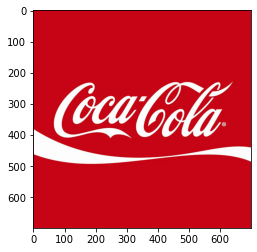

In [112]:
img_bgr = cv2.imread("coca-cola-logo.png")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
print(img_rgb.shape)
logo_w = img_rgb.shape[0]
logo_h = img_rgb.shape[1]

### <font color="green">Read Background image</font>

(700, 700, 3)


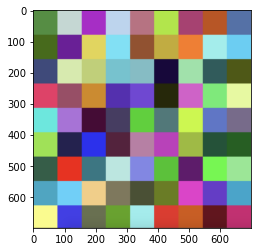

In [113]:
# Read in image of color cheackerboad background
img_background_bgr = cv2.imread("checkerboard_color.png")
img_background_rgb = cv2.cvtColor(img_background_bgr, cv2.COLOR_BGR2RGB)

# Set desired width (logo_w) and maintain image aspect ratio
aspect_ratio = logo_w / img_background_rgb.shape[1]
dim = (logo_w, int(img_background_rgb.shape[0] * aspect_ratio))

# Resize background image to same size as logo image
img_background_rgb = cv2.resize(img_background_rgb, dim, interpolation=cv2.INTER_AREA)

plt.imshow(img_background_rgb) 
print(img_background_rgb.shape)

### <font color="green">Create Mask for original Image</font>

(700, 700)


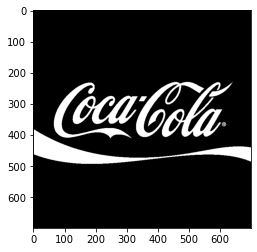

In [114]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Apply global thresholding to creat a binary mask of the logo
retval, img_mask = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)

plt.imshow(img_mask,cmap="gray")
print(img_mask.shape)

### <font color="green">Invert the Mask </font>

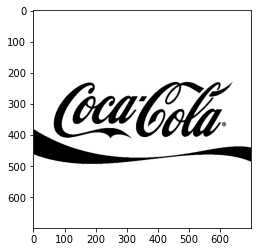

In [115]:
# Create an inverse mask
img_mask_inv = cv2.bitwise_not(img_mask)
plt.imshow(img_mask_inv,cmap="gray")

### <font color="green">Apply background on the Mask</font>

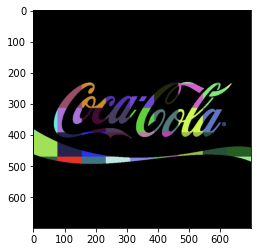

In [116]:
# Create colorful background "behind" the logo lettering
img_background = cv2.bitwise_and(img_background_rgb, img_background_rgb, mask=img_mask)
plt.imshow(img_background)

### <font color="green">Isolate foreground from image</font>

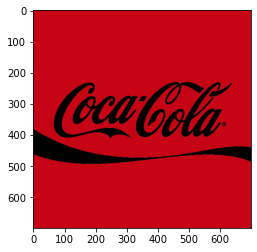

In [117]:
# Isolate foreground (red from original image) using the inverse mask
img_foreground = cv2.bitwise_and(img_rgb, img_rgb, mask=img_mask_inv)
plt.imshow(img_foreground)

### <font color="green">Result: Merge Foreground and Background</font>

True

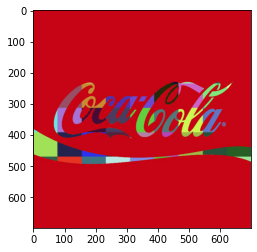

In [118]:
# Add the two previous results obtain the final result
result = cv2.add(img_background,img_foreground)
plt.imshow(result)
cv2.imwrite("logo_final.png", result[:,:,::-1])